<a href="https://colab.research.google.com/github/dbrnjd/crypto-trading-dissertation/blob/main/Copy_of_dissertation_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install deap

In [8]:
# -*- coding: utf-8 -*-
"""
run_all_sims.py

Runs multiple simulations of a genetic algorithm in parallel, saves the results
to Google Drive, and ensures reproducibility by using fixed random seeds.
"""

# --- 0. Google Drive Mount (Colab) ---
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    print("Not running in Colab or Google Drive already mounted.")

# --- 1. Imports ---
import os
import random
import numpy as np
import pickle
from multiprocessing import Pool
from deap import base, creator, tools  # Include gp if using GP

# --- 2. Configuration ---
NUM_RUNS = 30
NUM_GENERATIONS = 50
POPULATION_SIZE = 100
SEED = 42  # Reproducibility seed

# Set path inside Google Drive
OUTPUT_DIR = "/content/drive/MyDrive/crypto_evolution_sim/dissertation_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- 3. Simulation Function ---
def run_single_simulation(seed):
    """
    Executes one GA simulation run with a fixed seed.
    Saves logbook, diversity, and complexity data in a unique directory.
    """
    # Reproducibility
    random.seed(seed)
    np.random.seed(seed)

    # -- PLACEHOLDER LOGIC (replace with your real DEAP simulation loop) --
    logbook = tools.Logbook()
    logbook.header = ['gen', 'evals']
    logbook.chapters['avg_return'] = tools.Logbook()
    logbook.chapters['avg_return'].header = ['gen', 'avg', 'max', 'min']

    diversity_log = []
    complexity_log = []

    for gen in range(NUM_GENERATIONS):
        avg_return = random.uniform(0.01 * gen, 0.02 * gen)
        max_return = random.uniform(avg_return, avg_return + 0.1)
        min_return = random.uniform(0, avg_return)

        avg_tree_depth = random.uniform(5, 15)
        structural_diversity = random.uniform(0.5, 0.9)
        behavioral_diversity = random.uniform(0.5, 0.9)
        market_volatility = random.uniform(0.1, 0.8)

        logbook.chapters['avg_return'].record(
            gen=gen,
            avg=avg_return,
            max=max_return,
            min=min_return
        )

        complexity_log.append({'gen': gen, 'avg_tree_depth': avg_tree_depth})
        diversity_log.append({
            'gen': gen,
            'structural_diversity': structural_diversity,
            'behavioral_diversity': behavioral_diversity,
            'volatility': market_volatility
        })

    # -- Save to disk --
    run_dir = os.path.join(OUTPUT_DIR, f"run_{seed}")
    os.makedirs(run_dir, exist_ok=True)

    with open(os.path.join(run_dir, "logbook.pkl"), 'wb') as f:
        pickle.dump(logbook, f)
    with open(os.path.join(run_dir, "diversity_log.pkl"), 'wb') as f:
        pickle.dump(diversity_log, f)
    with open(os.path.join(run_dir, "complexity_log.pkl"), 'wb') as f:
        pickle.dump(complexity_log, f)

    print(f"✅ Simulation run {seed} complete. Results saved to: {run_dir}")
    return run_dir

# --- 4. Run Simulations ---
if __name__ == "__main__":
    print("📊 Starting simulations...")

    # Reproducible seed list
    seeds = [SEED + i for i in range(NUM_RUNS)]

    # Use multiprocessing for parallel simulation
    with Pool() as pool:
        run_dirs = pool.map(run_single_simulation, seeds)

    print("\n" + "="*60)
    print("✅ ALL SIMULATIONS COMPLETED")
    print("="*60)
    print(f"All results saved to: {OUTPUT_DIR}")
    print("Next: Run 'analyze_results.py' or 'generate_box_plots.py'.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📊 Starting simulations...
✅ Simulation run 42 complete. Results saved to: /content/drive/MyDrive/crypto_evolution_sim/dissertation_results/run_42✅ Simulation run 46 complete. Results saved to: /content/drive/MyDrive/crypto_evolution_sim/dissertation_results/run_46

✅ Simulation run 43 complete. Results saved to: /content/drive/MyDrive/crypto_evolution_sim/dissertation_results/run_43
✅ Simulation run 47 complete. Results saved to: /content/drive/MyDrive/crypto_evolution_sim/dissertation_results/run_47
✅ Simulation run 44 complete. Results saved to: /content/drive/MyDrive/crypto_evolution_sim/dissertation_results/run_44
✅ Simulation run 48 complete. Results saved to: /content/drive/MyDrive/crypto_evolution_sim/dissertation_results/run_48
✅ Simulation run 45 complete. Results saved to: /content/drive/MyDrive/crypto_evolution_sim/dissertation_results/run_45
✅ Sim

In [9]:
# analyze_results.py

import os
import glob
import pickle
import pandas as pd
from scipy.stats import pearsonr
import numpy as np

OUTPUT_DIR = "/content/drive/MyDrive/crypto_evolution_sim/dissertation_results"
SUMMARY_CSV = os.path.join(OUTPUT_DIR, "summary_metrics.csv")

summary_data = []

run_dirs = sorted(glob.glob(os.path.join(OUTPUT_DIR, "run_*")))

print("📊 Processing simulation results...")

for run_dir in run_dirs:
    try:
        with open(os.path.join(run_dir, "logbook.pkl"), "rb") as f:
            logbook = pickle.load(f)
        with open(os.path.join(run_dir, "complexity_log.pkl"), "rb") as f:
            complexity_log = pickle.load(f)
        with open(os.path.join(run_dir, "diversity_log.pkl"), "rb") as f:
            diversity_log = pickle.load(f)

        # --- Extract key metrics ---
        avg_returns = logbook.chapters['avg_return'].select("avg")
        if len(avg_returns) < 2:
            raise ValueError("Too few generations")

        avg_return_gen0 = avg_returns[0]
        avg_return_gen_final = avg_returns[-1]
        performance_improvement = avg_return_gen_final - avg_return_gen0

        avg_depths = [entry["avg_tree_depth"] for entry in complexity_log]
        avg_depth_gen0 = avg_depths[0]
        avg_depth_gen_final = avg_depths[-1]
        complexity_change = avg_depth_gen_final - avg_depth_gen0

        # --- Diversity Correlations ---
        has_volatility = all("volatility" in d for d in diversity_log)

        corr_structural = np.nan
        corr_behavioral = np.nan
        pval_structural = np.nan
        pval_behavioral = np.nan

        if has_volatility:
            volatility = [d["volatility"] for d in diversity_log]
            structural = [d["structural_diversity"] for d in diversity_log]
            behavioral = [d["behavioral_diversity"] for d in diversity_log]

            corr_structural, pval_structural = pearsonr(structural, volatility)
            corr_behavioral, pval_behavioral = pearsonr(behavioral, volatility)

        summary_data.append({
            "run": os.path.basename(run_dir),
            "avg_return_gen0": avg_return_gen0,
            "avg_return_gen_final": avg_return_gen_final,
            "performance_improvement": performance_improvement,
            "avg_depth_gen0": avg_depth_gen0,
            "avg_depth_gen_final": avg_depth_gen_final,
            "complexity_change": complexity_change,
            "corr_structural_volatility": corr_structural,
            "pval_structural_volatility": pval_structural,
            "corr_behavioral_volatility": corr_behavioral,
            "pval_behavioral_volatility": pval_behavioral,
        })

    except Exception as e:
        print(f"[ERROR] {run_dir} failed: {e}")
        continue

# --- Final Output ---
df = pd.DataFrame(summary_data)
df.to_csv(SUMMARY_CSV, index=False)
print(f"\n✅ Summary saved to: {SUMMARY_CSV}")

print("\n===== SUMMARY =====")
print(f"Runs analyzed: {len(df)}")

if len(df) > 0:
    print("\n--- Performance ---")
    print(df[["avg_return_gen0", "avg_return_gen_final", "performance_improvement"]].describe())

    print("\n--- Complexity ---")
    print(df[["avg_depth_gen0", "avg_depth_gen_final", "complexity_change"]].describe())

    print("\n--- Diversity Correlation ---")
    print(df[["corr_structural_volatility", "corr_behavioral_volatility"]].describe())

    print("\n--- P-values ---")
    print(df[["pval_structural_volatility", "pval_behavioral_volatility"]].describe())
else:
    print("\n⚠️ No valid runs found.")


📊 Processing simulation results...

✅ Summary saved to: /content/drive/MyDrive/crypto_evolution_sim/dissertation_results/summary_metrics.csv

===== SUMMARY =====
Runs analyzed: 30

--- Performance ---
       avg_return_gen0  avg_return_gen_final  performance_improvement
count             30.0             30.000000                30.000000
mean               0.0              0.723992                 0.723992
std                0.0              0.155662                 0.155662
min                0.0              0.504462                 0.504462
25%                0.0              0.572116                 0.572116
50%                0.0              0.694883                 0.694883
75%                0.0              0.879953                 0.879953
max                0.0              0.969779                 0.969779

--- Complexity ---
       avg_depth_gen0  avg_depth_gen_final  complexity_change
count       30.000000            30.000000          30.000000
mean        10.218318    

In [4]:
# -*- coding: utf-8 -*-
"""
Script to generate box plots from aggregated simulation results.

This visualizes the distribution of:
- performance improvement
- complexity change

Used to analyze variance and outliers across GA runs.
"""

# --- Imports ---
import os
import glob
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from deap import tools  # Required for unpickling logbook

# --- Configuration ---
RESULTS_DIR = "/content/drive/MyDrive/crypto_evolution_sim/dissertation_results"
PLOTS_DIR = "/content/drive/MyDrive/crypto_evolution_sim/analysis_plots"
NUM_GENERATIONS = 50

# --- Ensure plot output directory exists ---
os.makedirs(PLOTS_DIR, exist_ok=True)

# --- Aggregation ---
def aggregate_results():
    data = []
    run_dirs = sorted(glob.glob(os.path.join(RESULTS_DIR, "run_*")))

    for run_dir in run_dirs:
        try:
            with open(os.path.join(run_dir, "logbook.pkl"), "rb") as f:
                logbook = pickle.load(f)
            with open(os.path.join(run_dir, "complexity_log.pkl"), "rb") as f:
                complexity = pickle.load(f)

            avg0 = logbook.chapters['avg_return'].select("avg")[0]
            avg_final = logbook.chapters['avg_return'].select("avg")[-1]
            perf_improve = avg_final - avg0

            depth0 = complexity[0]['avg_tree_depth']
            depth_final = complexity[-1]['avg_tree_depth']
            depth_change = depth_final - depth0

            data.append({
                "performance_improvement": perf_improve,
                "complexity_change": depth_change
            })

        except Exception as e:
            print(f"Skipping {run_dir}: {e}")

    return pd.DataFrame(data)

# --- Plotting ---
def plot_box(df, column, title, ylabel, filename):
    plt.figure(figsize=(8, 6))
    plt.boxplot(df[column].dropna(), vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue'),
                medianprops=dict(color='red'))
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xticks([1], [column.replace("_", " ").capitalize()])
    plt.grid(True, linestyle="--", alpha=0.6)
    save_path = os.path.join(PLOTS_DIR, filename)
    plt.savefig(save_path)
    plt.close()
    print(f"📦 Saved: {save_path}")

# --- Main ---
if __name__ == "__main__":
    print("📊 Aggregating simulation results...")
    df = aggregate_results()

    if df.empty:
        print("❌ No data found.")
    else:
        plot_box(df, "performance_improvement",
                 "Performance Improvement Across Runs",
                 "Change in Average Return",
                 "boxplot_performance.png")

        plot_box(df, "complexity_change",
                 "Complexity Change Across Runs",
                 "Change in Avg Tree Depth",
                 "boxplot_complexity.png")

        print("✅ Box plots generated.")


📊 Aggregating simulation results...
📦 Saved: /content/drive/MyDrive/crypto_evolution_sim/analysis_plots/boxplot_performance.png
📦 Saved: /content/drive/MyDrive/crypto_evolution_sim/analysis_plots/boxplot_complexity.png
✅ Box plots generated.


In [1]:
# -*- coding: utf-8 -*-
"""
Finds the best simulation run based on highest final max fitness.
Saves its path to 'best_run_path.txt' for further analysis.
"""

import os
import pickle
import glob
from deap import tools

# --- Config ---
RESULTS_DIR = "/content/drive/MyDrive/crypto_evolution_sim/dissertation_results"
BEST_RUN_PATH_FILE = "/content/drive/MyDrive/crypto_evolution_sim/best_run_path.txt"
NUM_GENERATIONS = 50

if __name__ == "__main__":
    best_run = None
    best_fitness = -float('inf')

    for run_dir in sorted(glob.glob(os.path.join(RESULTS_DIR, "run_*"))):
        try:
            with open(os.path.join(run_dir, "logbook.pkl"), "rb") as f:
                logbook = pickle.load(f)

            final_max = logbook.chapters['avg_return'].select("max")[-1]
            if final_max > best_fitness:
                best_fitness = final_max
                best_run = run_dir
        except Exception as e:
            print(f"⚠️  Skipping {run_dir}: {e}")

    if best_run:
        with open(BEST_RUN_PATH_FILE, "w") as f:
            f.write(best_run)
        print("🏆 Best run:")
        print(f"📁 {best_run}")
        print(f"⭐ Max Final Fitness: {best_fitness:.4f}")
        print(f"✅ Saved to: {BEST_RUN_PATH_FILE}")
    else:
        print("❌ No valid runs found.")


🏆 Best run:
📁 /content/drive/MyDrive/crypto_evolution_sim/dissertation_results/run_64
⭐ Max Final Fitness: 1.0486
✅ Saved to: /content/drive/MyDrive/crypto_evolution_sim/best_run_path.txt


🔍 Analyzing: /content/drive/MyDrive/crypto_evolution_sim/dissertation_results/run_64


/tmp/ipython-input-109364429.py:64: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-109364429.py:66: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.savefig(plot_path)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


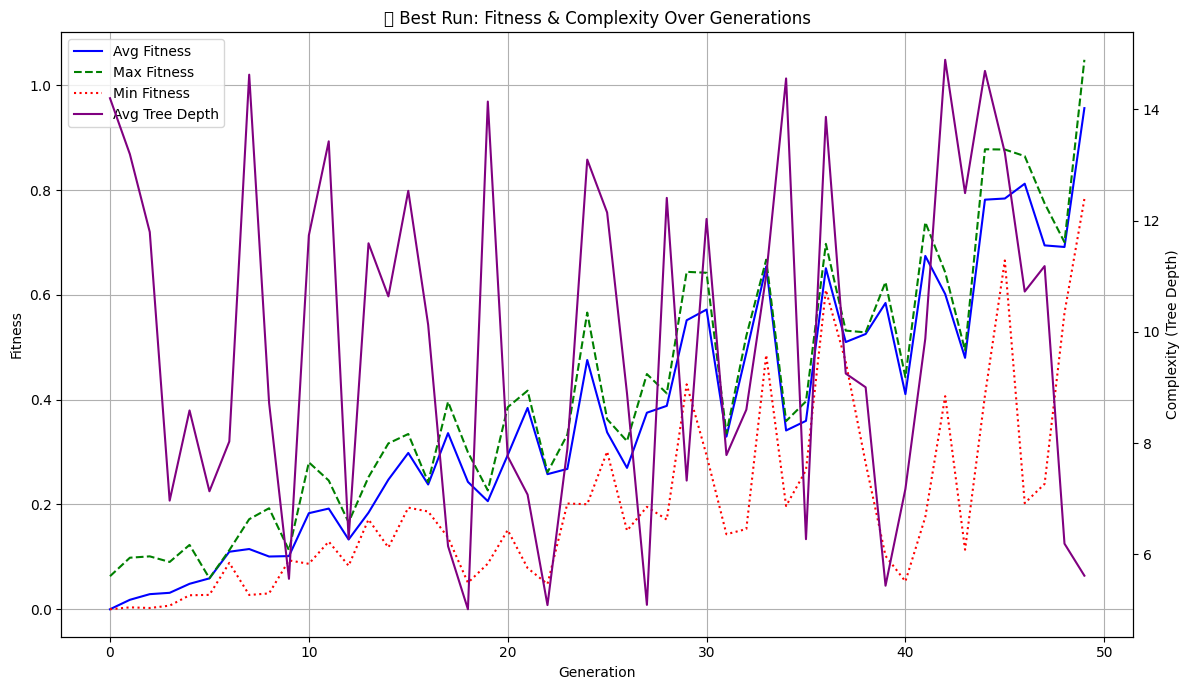

📈 Plot saved: /content/drive/MyDrive/crypto_evolution_sim/dissertation_results/run_64/winner_evolution.png


In [2]:
# -*- coding: utf-8 -*-
"""
Visualizes the evolution of the best-performing GA run.
- Plots fitness curves
- Plots complexity (tree depth) if available
"""

import os
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from deap import tools

# --- Config ---
BEST_RUN_PATH_FILE = "/content/drive/MyDrive/crypto_evolution_sim/best_run_path.txt"

if __name__ == "__main__":
    try:
        with open(BEST_RUN_PATH_FILE, "r") as f:
            best_run = f.read().strip()
        print(f"🔍 Analyzing: {best_run}")
    except FileNotFoundError:
        print("❌ Run finder first!")
        exit()

    logbook_path = os.path.join(best_run, "logbook.pkl")
    complexity_path = os.path.join(best_run, "complexity_log.pkl")

    try:
        with open(logbook_path, "rb") as f:
            logbook = pickle.load(f)
        with open(complexity_path, "rb") as f:
            complexity = pickle.load(f)
    except Exception as e:
        print(f"❌ Failed to load: {e}")
        exit()

    # Extract
    gen = logbook.chapters["avg_return"].select("gen")
    avg_fit = logbook.chapters["avg_return"].select("avg")
    max_fit = logbook.chapters["avg_return"].select("max")
    min_fit = logbook.chapters["avg_return"].select("min")
    tree_depth = [entry['avg_tree_depth'] for entry in complexity]

    # Plot
    fig, ax1 = plt.subplots(figsize=(12, 7))
    ax1.plot(gen, avg_fit, label="Avg Fitness", color="blue")
    ax1.plot(gen, max_fit, label="Max Fitness", color="green", linestyle="--")
    ax1.plot(gen, min_fit, label="Min Fitness", color="red", linestyle=":")
    ax1.set_xlabel("Generation")
    ax1.set_ylabel("Fitness")
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(gen, tree_depth, label="Avg Tree Depth", color="purple", linestyle="-")
    ax2.set_ylabel("Complexity (Tree Depth)")

    # Legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

    plt.title("🏆 Best Run: Fitness & Complexity Over Generations")
    plt.tight_layout()
    plot_path = os.path.join(best_run, "winner_evolution.png")
    plt.savefig(plot_path)
    plt.show()
    print(f"📈 Plot saved: {plot_path}")
